## Evasion attack and poisoning attack on SVM

In [278]:
import secml
import secml.ml
import secml.ml.classifiers
import sklearn
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [29]:
from secml.ml.classifiers.sklearn.c_classifier_sklearn import CClassifierSkLearn

In [30]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1, n_classes=2)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

In [101]:
dataset

CDataset{'X': CArray(300, 2)(dense: [[-1.906134 -1.636146] [ 2.561638  1.189882] [ 1.380388  1.39452 ] ... [-0.033437  0.474928] [-0.779699  0.8821  ] [-2.242112 -2.000074]]), 'Y': CArray(300,)(dense: [0 1 1 ... 1 1 0]), 'header': None}

In [35]:
X, y = datasets[0]
h = .02

([], [])

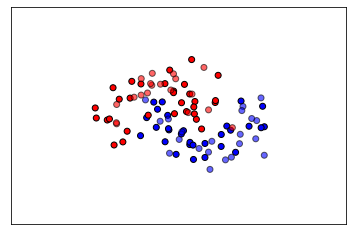

In [279]:
X = minmax_scale(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# # just plot the dataset first
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# # Plot the training points
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#            edgecolors='k')
# # Plot the testing points
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
#            edgecolors='k')
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())

In [280]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [281]:
clf = SVC(gamma=2, C=1)
clf.fit(X_train, y_train)

SVC(C=1, gamma=2)

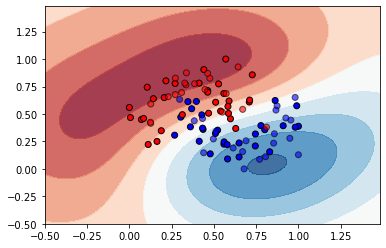

In [282]:
# score = clf.score(X_test, y_test)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)

# ax.set_xlim(xx.min(), xx.max())
# ax.set_ylim(yy.min(), yy.max())
# ax.set_xticks(())
# ax.set_yticks(())
# if ds_cnt == 0:
#     ax.set_title(name)
# ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#         size=15, horizontalalignment='right')

### Evasion Attack

In [321]:
train = CDataset(X_train, y_train)
val = CDataset(X_test, y_test)

In [322]:
from secml.array import CArray
from secml.data import CDataset
from secml.ml.classifiers import CClassifierSVM

In [323]:
clf = CClassifierSVM(C=1, kernel="rbf")

In [324]:
clf = clf.fit(train.X, train.Y)

In [326]:
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = None, None  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.3,
    'eta_min': 0.1,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-4
}


In [327]:
from secml.adv.attacks.evasion import CAttackEvasion, CAttackEvasionPGDLS,  CAttackEvasionPGD

In [333]:
idx = 2
x0, y0 = train[idx, :].X, train[idx, :].Y  # Initial sample

In [334]:
pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=clf,
    double_init_ds=train,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

# Run the evasion attack on x0
y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)

In [335]:
print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-LS): ", y_pred_pgdls.item())

print("Number of classifier gradient evaluations: {:}"
      "".format(pgd_ls_attack.grad_eval))

Original x0 label:  1
Adversarial example label (PGD-LS):  0
Number of classifier gradient evaluations: 10


In [336]:
attack  = pgd_ls_attack
adv_ds  = adv_ds_pgdls

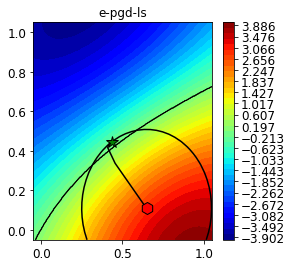

In [337]:
from secml.figure import CFigure
fig = CFigure(width=4, height=4, markersize=12)

# Let's replicate the `l2` constraint used by the attack for visualization
from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=dmax)

fig.sp.plot_fun(attack.objective_function, plot_levels=True,
                    multipoint=True, n_grid_points=200)
# Let's also plot the decision boundaries of the classifier
fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

# Construct an array with the original point and the adversarial example
adv_path = x0.append(adv_ds.X, axis=0)

# Convenience function for plotting the optimization sequence
fig.sp.plot_path(attack.x_seq)

# Convenience function for plotting a constraint
fig.sp.plot_constraint(constraint)

fig.sp.title(attack.class_type)
fig.sp.grid(grid_on=False)

### Poisoning attack

In [338]:
y_pred = clf.predict(val.X)

In [339]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 20  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=train,
                                  val=val,
                                  lb=val.X.min(), ub=val.X.max(),
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(val.X, val.Y, max_iter=10)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=val.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=val.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Attack started...
Attack complete!
Original accuracy on test set: 87.50%
Accuracy after attack on test set: 62.50%


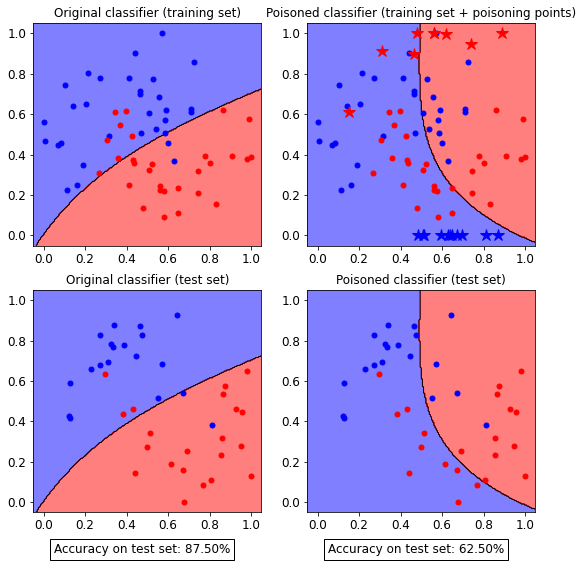

In [346]:
# Training of the poisoned classifier
pois_clf = clf.deepcopy()
pois_tr = train.append(pois_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

# Define common bounds for the subplots
min_limit = min(pois_tr.X.min(), ts.X.min())
max_limit = max(pois_tr.X.max(), ts.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

from secml.figure import CFigure
fig = CFigure(9, 9)

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(train, markersize=5)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (training set + poisoning points)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(train, markersize=5)
fig.sp.plot_ds(pois_ds, markers=['*', '*'], markersize=12)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (test set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(val, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc),
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (test set)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(val, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc),
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.show()